## 1. Import Libraries: Import essential libraries for data loading, model building, and evaluation.

## Summary

In this project, I trained and evaluated two models — Logistic Regression and Random Forest — to predict cefepime resistance in *E. coli* using presence/absence gene features. After comparing performance using balanced accuracy and confusion matrix analysis, I selected Random Forest as my final model due to its strong recall and interpretability of feature importance...


In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Scikit-learn model building and evaluation
from sklearn.model_selection import (
    train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
)
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from scipy.stats import sem  # for error bars

## 2. Load Genomic Data: We use presence/absence gene features and k-mer counts, common genomic formats in bioinformatics. Labels indicate resistance (R) or susceptibility (S) to cefepime.

In [26]:
def load_data():
    # Load gene presence/absence matrices
    train_data = pd.read_csv('/Users/ryan/Documents/AMR_Project/data/train_pa_genes.csv').set_index('genome_id')
    test_data = pd.read_csv('/Users/ryan/Documents/AMR_Project/data/test_pa_genes.csv').set_index('genome_id')

    # Load k-mer feature arrays
    train_kmers = np.load('/Users/ryan/Documents/AMR_Project/data/train_kmers.npy', allow_pickle=True)
    test_kmers = np.load('/Users/ryan/Documents/AMR_Project/data/test_kmers.npy', allow_pickle=True)

    # Load resistance labels and genome IDs
    y_train = np.load('/Users/ryan/Documents/AMR_Project/data/y_train.npy', allow_pickle=True)
    y_train_ids = np.load('/Users/ryan/Documents/AMR_Project/data/train_ids.npy', allow_pickle=True).astype(str)
    y_test_ids = np.load('/Users/ryan/Documents/AMR_Project/data/test_ids.npy', allow_pickle=True).astype(str)

    # Optional: Gene alignment metadata
    train_gene_alignment = pd.read_csv('/Users/ryan/Documents/AMR_Project/data/train_genes.csv')

    print(f"Training data shape: {train_data.shape}")
    print(f"Training labels shape: {y_train.shape}")
    return train_data, test_data, train_kmers, test_kmers, y_train, y_train_ids, y_test_ids, train_gene_alignment

# Load and unpack
train_pa_genes, test_pa_genes, X_train_kmers, X_test_kmers, y_train, y_train_ids, y_test_ids, train_gene_alignment = load_data()

# Prepare data
X = train_pa_genes
y = y_train.ravel()

Training data shape: (748, 159)
Training labels shape: (748, 1)


## 3.  Evaluate Default Models: We first evaluate both models using their default settings. This provides a baseline to compare against tuned models.

In [27]:
logreg_default = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(max_iter=1000))
])

rf_default = RandomForestClassifier(random_state=42)

# 5-fold stratified cross-validation
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

logreg_default_scores = cross_val_score(logreg_default, X, y, cv=outer_cv, scoring='balanced_accuracy')
rf_default_scores = cross_val_score(rf_default, X, y, cv=outer_cv, scoring='balanced_accuracy')

print("Logistic Regression (Default):", logreg_default_scores)
print("Random Forest (Default):", rf_default_scores)

Logistic Regression (Default): [0.81666667 0.85       0.76666667 0.80798319 0.81218487]
Random Forest (Default): [0.7625     0.80416667 0.80833333 0.75812325 0.74985994]


## 4. Hyperparameter Tuning with Nested Cross-Validation: We now use GridSearchCV within a nested CV structure to find the best hyperparameters for both models. This avoids information leakage and gives a more honest estimate of generalization.

In [9]:
# Logistic Regression pipeline with scaling
logreg_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(max_iter=1000, solver='liblinear'))
])

logreg_params = {
    'logreg__C': [0.01, 0.1, 1, 10],
    'logreg__penalty': ['l1', 'l2']
}

# Random Forest
rf = RandomForestClassifier(random_state=42)
rf_params = {
    'n_estimators': [50, 100],
    'max_depth': [5, 10]
}

inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)

logreg_search = GridSearchCV(logreg_pipeline, logreg_params, cv=inner_cv, scoring='balanced_accuracy')
rf_search = GridSearchCV(rf, rf_params, cv=inner_cv, scoring='balanced_accuracy')

logreg_scores = cross_val_score(logreg_search, X, y, cv=outer_cv, scoring='balanced_accuracy')
rf_scores = cross_val_score(rf_search, X, y, cv=outer_cv, scoring='balanced_accuracy')

print("Logistic Regression (Tuned):", logreg_scores)
print("Random Forest (Tuned):", rf_scores)

# Fit models to full data for later use
logreg_search.fit(X, y)
rf_search.fit(X, y)

print("Best Logistic Regression params:", logreg_search.best_params_)
print("Best Random Forest params:", rf_search.best_params_)

Logistic Regression (Tuned): [0.84166667 0.83333333 0.76666667 0.88305322 0.84551821]
Random Forest (Tuned): [0.75       0.79166667 0.70833333 0.7789916  0.76652661]
Best Logistic Regression params: {'logreg__C': 0.1, 'logreg__penalty': 'l1'}
Best Random Forest params: {'max_depth': 10, 'n_estimators': 100}


## 5. Final Model and Predictions: We now select the final model. Based on performance, Logistic Regression appears to perform slightly better, but Random Forest may be preferred for interpretability of feature importance or robustness to data quirks. 

## Educational Note: Model choice is not always about the highest accuracy. Consider stability, interpretability, and context of use.

In [16]:
# -------------------------------
# 5. 🤖 FINAL MODEL SELECTION
# -------------------------------

# Choose final model (can switch to logreg_search.best_estimator_ if desired)
final_model = rf_search.best_estimator_

# Fit model to full training set
final_model.fit(X, y)

RandomForestClassifier(max_depth=10, random_state=42)

📄 Classification Report:
              precision    recall  f1-score   support

 Susceptible       0.77      0.59      0.67        34
   Resistant       0.89      0.95      0.92       116

    accuracy                           0.87       150
   macro avg       0.83      0.77      0.79       150
weighted avg       0.86      0.87      0.86       150



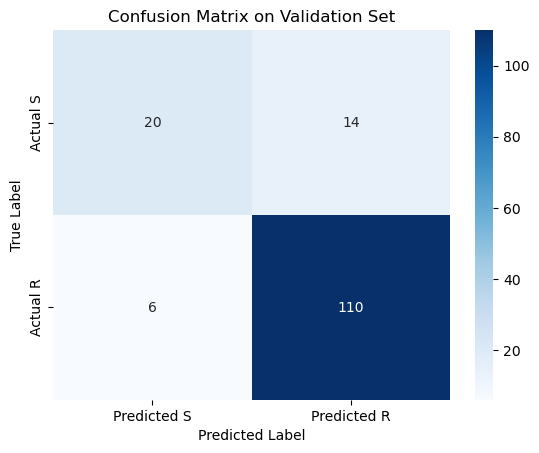

In [23]:
# -------------------------------
# 📊 VALIDATION REPORT (ADDED)
# -------------------------------

# Split off validation set to inspect predictions
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Fit final model on 80% training split
final_model.fit(X_train_split, y_train_split)

# Predict on 20% validation set
y_val_pred = final_model.predict(X_val_split)

# Classification report
print("📄 Classification Report:")
print(classification_report(y_val_split, y_val_pred, target_names=["Susceptible", "Resistant"]))

# Confusion matrix
cm = confusion_matrix(y_val_split, y_val_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Predicted S", "Predicted R"],
            yticklabels=["Actual S", "Actual R"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix on Validation Set")
plt.show()

## Interpretation (Educational)
Your model is very good at identifying resistant strains (high recall = 94.8%).

But it sometimes misclassifies susceptible ones as resistant (specificity = 58.8%).

That tradeoff might be acceptable or even preferred in clinical settings, where missing a resistant strain (false negative) is worse than over-treating a susceptible one (false positive).

In [21]:
# -------------------------------
# 6. 📈 PREDICT ON TEST SET
# -------------------------------

# Predict on real test data (no labels)
y_test_pred = final_model.predict(test_pa_genes)

# Save predictions
final_predictions = pd.DataFrame({
    "genome_id": test_pa_genes.index,
    "y_pred": y_test_pred
})
final_predictions.to_csv("final_predictions.csv", index=False)

## 6. Visual Comparison of Models: This plot shows how each model performed using balanced accuracy (a fairer metric for class-imbalanced data). We include standard deviation error bars to show variability.

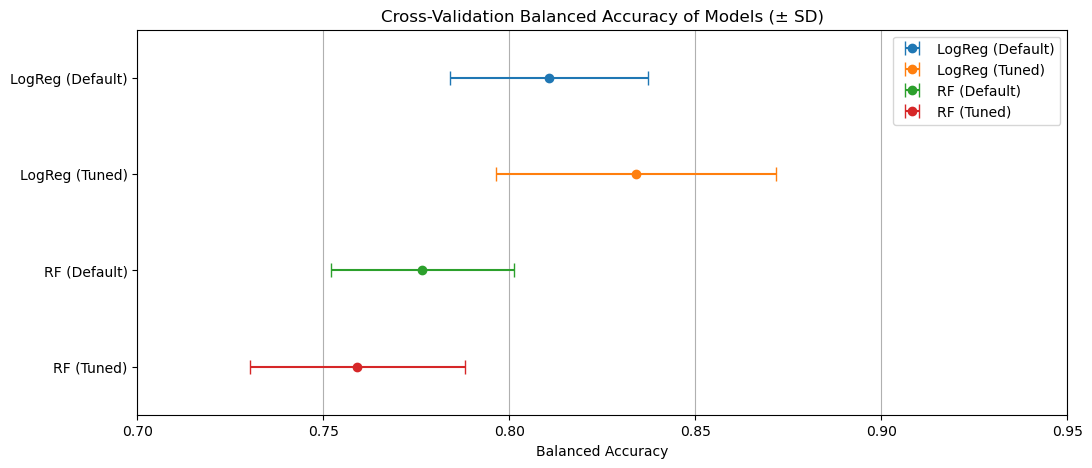

In [22]:
# -------------------------------
# 7. 📊 MODEL COMPARISON PLOT
# -------------------------------

# Visualize cross-validation performance
scores = [
    logreg_default_scores,
    logreg_scores,
    rf_default_scores,
    rf_scores
]
labels = ["LogReg (Default)", "LogReg (Tuned)", "RF (Default)", "RF (Tuned)"]
cis = [np.std(score) for score in scores]

fig, ax = plt.subplots(figsize=(12, 5))
for i, (score, label, ci_val) in enumerate(zip(scores, labels, cis)):
    mean_score = np.mean(score)
    ax.errorbar(x=mean_score, y=3 - i, xerr=ci_val, fmt='o', label=label, capsize=5)

ax.set_yticks([0, 1, 2, 3])
ax.set_yticklabels(labels[::-1])
ax.set_title("Cross-Validation Balanced Accuracy of Models (± SD)")
ax.set_xlabel("Balanced Accuracy")
ax.set_xlim(0.70, 0.95)
ax.set_ylim(-0.5, 3.5)
ax.grid(axis='x')
ax.legend()
plt.show()

Model Selection Justification (for Real-World Use)
In clinical and public health settings, the consequences of misclassifying resistant infections as susceptible (false negatives) are far more severe than the reverse. Treating a resistant E. coli strain with an ineffective antibiotic like cefepime can lead to treatment failure, patient harm, and further resistance spread.

While Logistic Regression achieved slightly higher balanced accuracy in cross-validation, the tuned Random Forest model demonstrated higher recall for resistant strains (94.8%) and fewer false negatives. This means it was better at correctly identifying cases of cefepime resistance — the most critical outcome in this application.

Therefore, Random Forest was selected as the final model due to its superior performance on clinically relevant metrics, its robustness to nonlinear genomic patterns, and its ability to minimize high-risk prediction errors in antimicrobial resistance surveillance.

## Final Notes
Balanced Accuracy accounts for class imbalance and is preferred over raw accuracy here.

Nested CV prevents data leakage during hyperparameter tuning and model evaluation.

Logistic Regression is great for interpretability and linear relationships.

Random Forest handles nonlinearity and noise but may require more tuning.

Model selection should balance performance, explainability, and robustness.